# Init

## Imports

In [1]:
# Python modules
import itertools
import time

# Data management
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="ticks", font="Source Sans Pro", font_scale=.9, palette="muted")

# Fitting
import scipy.optimize as opt

# Project modules
import luescher_nd.utilities as ut
import luescher_nd.zeta as zeta

In [2]:
%load_ext blackcellmagic

## Parameters

Quantities will be expressed in units of [fm]. Energies are converted to inverse fermi using $\hbar c = 197.326$ MeV/fm.

In [3]:
HBARC = 197.326 # MeV / fm
M_NUCLEON = (938.27 + 939.57) / 2 / HBARC # in fm^{-1}

In [4]:
def energy2x(energy, mass, L):
    """
    """
    x_ = np.sqrt(np.abs(energy) * 2 * mass) * L / 2 / np.pi
    x_ *= x_
    
    return np.where(energy > 0, x_, -x_)

## 2-D

## Functions

Test the convergence of the 2-D zeta function

In [5]:
x = np.linspace(-4, 10, 1000)

lambdas = [100, 200, 500]

data = []

for l in lambdas:
    for xi, yi in zip(x, zeta.zeta2(x, l)):
        assert zeta.zeta2([xi], l) == yi
        data.append({"x": xi, "y": yi, "l": l})

z2_data = pd.DataFrame(data)

Extract numerical divergencies of $S_2$

In [6]:
divergencies = np.unique( np.sum(
        np.array(
            list(itertools.product(*[np.arange(int(x.min()), int(x.max()))] * 2)),
            dtype=float,
        )
        ** 2,
        axis=1,
    ) 
)
divergencies

array([  0.,   1.,   2.,   4.,   5.,   8.,   9.,  10.,  13.,  16.,  17.,
        18.,  20.,  25.,  26.,  29.,  32.,  34.,  36.,  37.,  40.,  41.,
        45.,  49.,  50.,  52.,  53.,  58.,  61.,  64.,  65.,  68.,  72.,
        73.,  74.,  80.,  81.,  82.,  85.,  89.,  90.,  97.,  98., 100.,
       106., 113., 117., 128., 130., 145., 162.])

Find zeros of $S_2$

In [7]:
lmax = z2_data.l.max()

n_zeros = 8
lower = -2
zeros = []
for upper in divergencies[:n_zeros]:
    res = opt.minimize(
        lambda x: zeta.zeta2([x], 2000)**2, 
        (lower+upper)*1./2, 
        tol=1.e-12,
        bounds=((lower*1.1, upper*0.9),)
    )
    zeros.append(res.x)
    lower = upper

-2 0.0
0.0 1.0
1.0 2.0
2.0 4.0
4.0 5.0
5.0 8.0
8.0 9.0
9.0 10.0


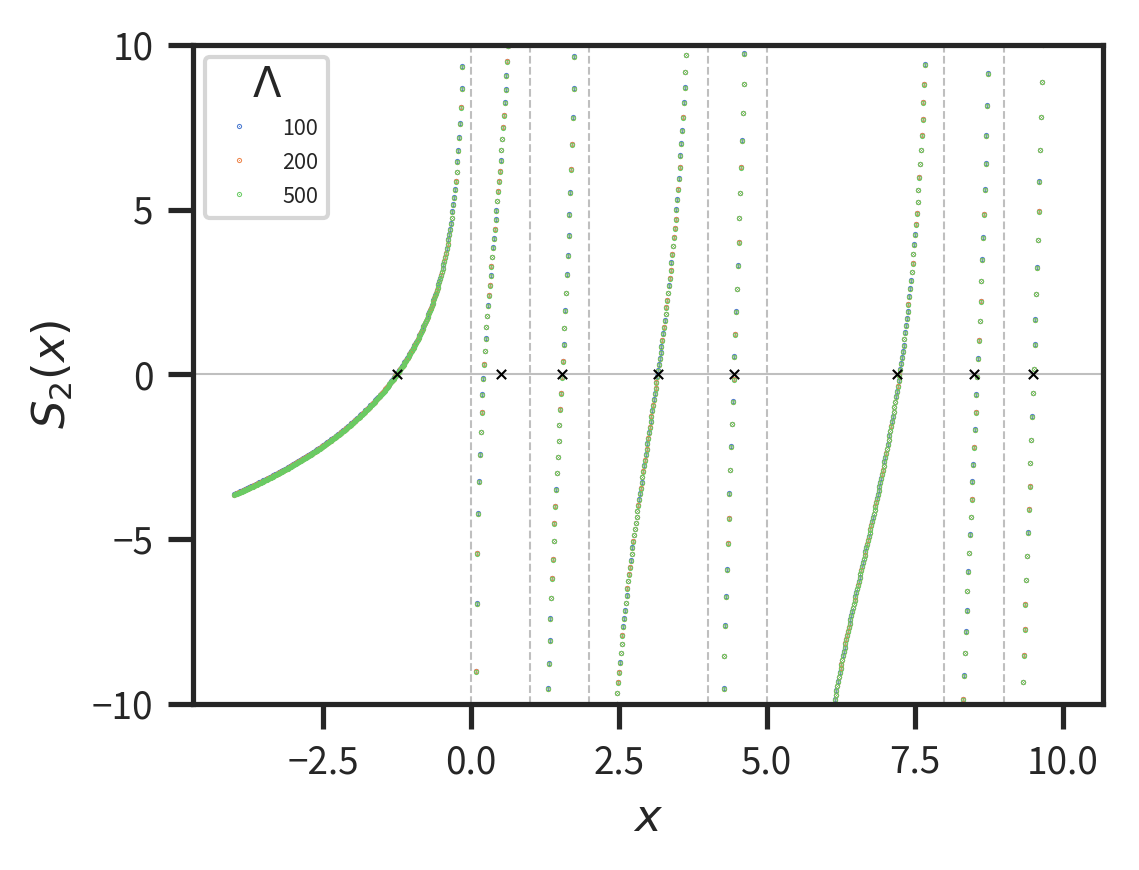

In [8]:
fig_zeta_2d, axs = plt.subplots(dpi=300, figsize=(4,3), ncols=1, sharey=True, sharex=True)

for ax in [axs]:
    ax.axhline(0, ls="-", c="grey", lw=.5, alpha=.5)

    for div in divergencies:
        if div < x.max():
            ax.axvline(div, ls="--", c="grey", lw=.5, alpha=.5)

    grouped = z2_data.groupby("l")
    for key, group in grouped:
        group.plot(ax=ax, x='x', y='y', label=key, lw=1, ls="None", marker=".", ms=.5)

    for zero in zeros:
        if zero < x.max():
            ax.scatter(zero, 0, marker="x", c="black", lw=.5, s=5, zorder=10)

    ax.set_ylim(-10, 10)
    ax.legend(loc="best", fontsize="xx-small", title="$\Lambda$")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$S_2(x)$")

plt.tight_layout()
plt.show(fig_zeta_2d)


## Fitting

Fit $c_0(a)$ such that $E = E(x_0, L)$, where

$$x_0 = \left( \frac{\gamma L}{2 \pi} \right)^2 = \frac{\mu E L^2}{2\pi^2} = -1.25107628$$

In [9]:
mu = M_NUCLEON / 2
L = 1.
print(zeros)
E0 = zeros[0] * 2 * np.pi**2 / mu / L**2
E0

[array([-1.25107628]), array([0.5]), array([1.53861637]), array([3.15371416]), array([4.43976008]), array([7.2]), array([8.5]), array([9.5])]


array([-10.38004527])

Fit

In [10]:
epsilons = [0.1, 0.08, 0.05, 0.02, 0.01]

data = []

def func(c0):
    return (solver.get_energies(c0, n_energies=1) - E0)**2

for epsilon in epsilons:
    n1d_max = int(L / epsilon)
    solver = ut.Solver(n1d_max=n1d_max, ndim_max=2, lattice_spacing=epsilon)

    c0 = -1.

    res = opt.minimize(func, c0)
    energies = solver.get_energies(res.x, n_energies=24)
    
    data.append({
        "a": epsilon,
        "c": res.x[0],
        "e": energies,
    })
    
df = pd.DataFrame(data)

Plot

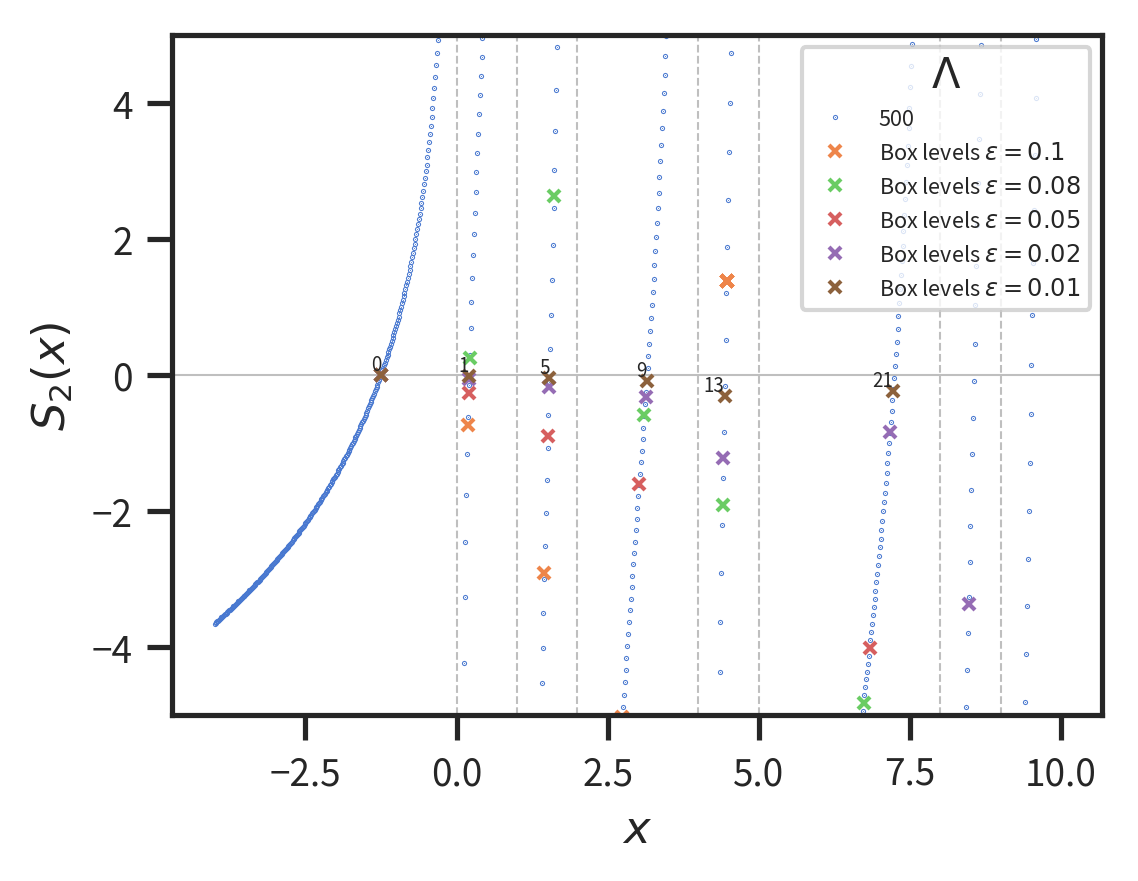

In [12]:
fig, ax = plt.subplots(dpi=300, figsize=(4,3))

ax.axhline(0, ls="-", c="grey", lw=.5, alpha=.5)

for div in divergencies:
    if div < x.max():
        ax.axvline(div, ls="--", c="grey", lw=.5, alpha=.5)
        
group = z2_data.query("l == @lmax")
group.plot(ax=ax, x='x', y='y', label=key, ls="None", ms=.5, marker=".")
    
y_min = -5
y_max = +5
   
nc = 0

for epsilon, energies in df[["a", "e"]].get_values():
    x0 = energy2x(energies, mu, L)
    y0 = zeta.zeta2(x0, 2000)

    ax.plot(x0, y0, "x", ms=3, lw=.5, label=rf"Box levels $\epsilon={epsilon}$")

    if nc == len(epsilons)-1:
        for i, (xi, yi) in enumerate(zip(x0, y0)):
            if yi < y_max and yi > y_min and xi < x.max() and xi > x.min():
                ax.text(
                    xi, yi, i, fontdict={"size": 5}, ha="right", va="bottom", withdash=True
                )
    nc += 1

ax.set_ylim(y_min, y_max)
ax.legend(loc="best", fontsize="xx-small", title="$\Lambda$")

ax.set_xlabel("$x$")
ax.set_ylabel("$S_2(x)$")

plt.show(fig_zeta_2d)